# Report: Customer segmentation with Arvato

Udacity Capstone project

Date of report: 26.08.2022 /
Author: Markus Stachl /
Programme: Data Science Nanodegree /
From: Udacity - School of Artificial Intelligence 

### Table of Contents

1. [Project definition](#definition)
    1. [Project overview](#overview) 
    1. [Problem statement](#statement)
    1. [Datasets](#datasets)
    1. [Metrics](#metrics)
2. [Analysis and data exploration](#analysis)
3. [Methodology](#methodology)
    1. [Preprocessing](#preprocessing)
    1. [Implementation](#implementation)
4. [Results](#results)
5. [Conclusion](#conclusion)

## Project definition <a name="definition"></a>

### Project overview <a name="overview"></a>

In the project, a mail-order sales company in Germany is interested in identifying segments of the general population to target with their marketing in order to grow. Demographics information has been provided for both the general population at large as well as for prior customers of the mail-order company in order to build a model of the customer base of the company. The target dataset contains demographics information for targets of a mailout marketing campaign.

The goal of the project is twofold:

- Supervised learning: Cluster the datasets into groups to find out characteristics of existing customers and their differences to the general population. By doing so I hope to gain insight into demographics data and which part of the general populatioon is probable to use provided services and therefore lucrative to be targeted by the marketing campain.
- Unsupervised learning: Develop a forecasting model to predict and identify prospective customer response for a marketing campaign.

This project is the final assignment and requirement for the completion of the Data Science Nanodegree at Udacity (School of AI). It was made possible by Arvato Financial Services, who kindly gave us (restricted) access to their data. All used datasets are sole private property of Arvato and exclusively used
for this project.

Access to the analysis is given here: https://github.com/mstachl/Customer_Segmentation.

### Problem statement <a name="statement"></a>

**“How can a company efficiently target people and acquire new customers when access to demographics data is provided?”**

In the first phase, the current customer base will be compared to the general population in Germany. This is done using by clustering indivuals based on personal attributes (type of household, family, educational and financial background, community).

In the second phase, predictions about not yet customers are done if they are likely to be new customers. This is done via classification.

### Datasets <a name="datasets"></a>

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

### Metrics <a name="metrics"></a>

The classification models are evaluated via the **AUC ROC** curve, i.e. the Area Under the Curve (AUC) for the Receiver Operating
Characteristic (ROC). 

Significant class imbalances in the MAILOUT_TEST (training data for predictions) dataset motivates us to use this
metric, instead of other accuracy scores, which would have heavily been impacted by the imbalance.

The Kaggle competition leaderboard can be accessed here: https://www.kaggle.com/c/udacity-arvato-identify-customers/leaderboard.

## Analysis and data exploration <a name="analysis"></a>

- **Understand the data**

I will start our analysis of AZDIAS and CUSTOMERS which are the primary datasets for this project.

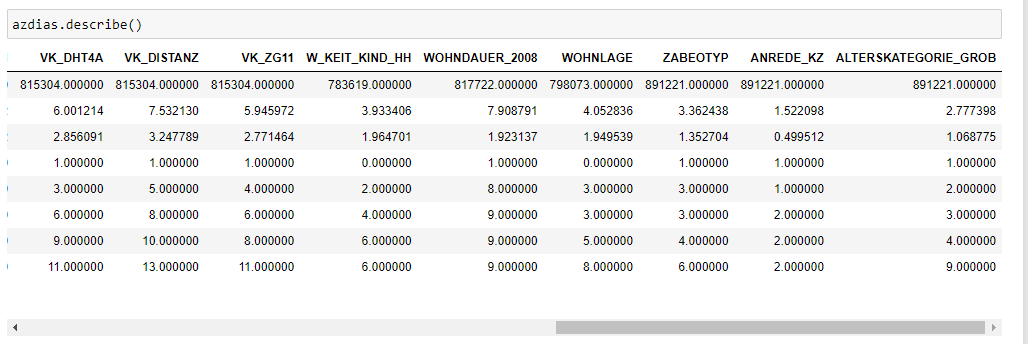

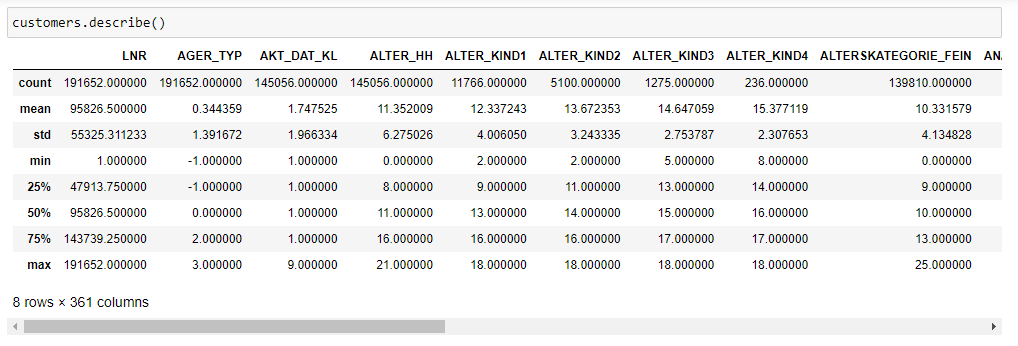



- **Missing data**

One of the first steps in data exploration is to collect information about missing data in the dataset as this in many cases is one of the key element that some time get overlooked and affects ML model significantly. Identifying and understanding missing data information at earlier stage will help us come up with data processing tasks accordingly.

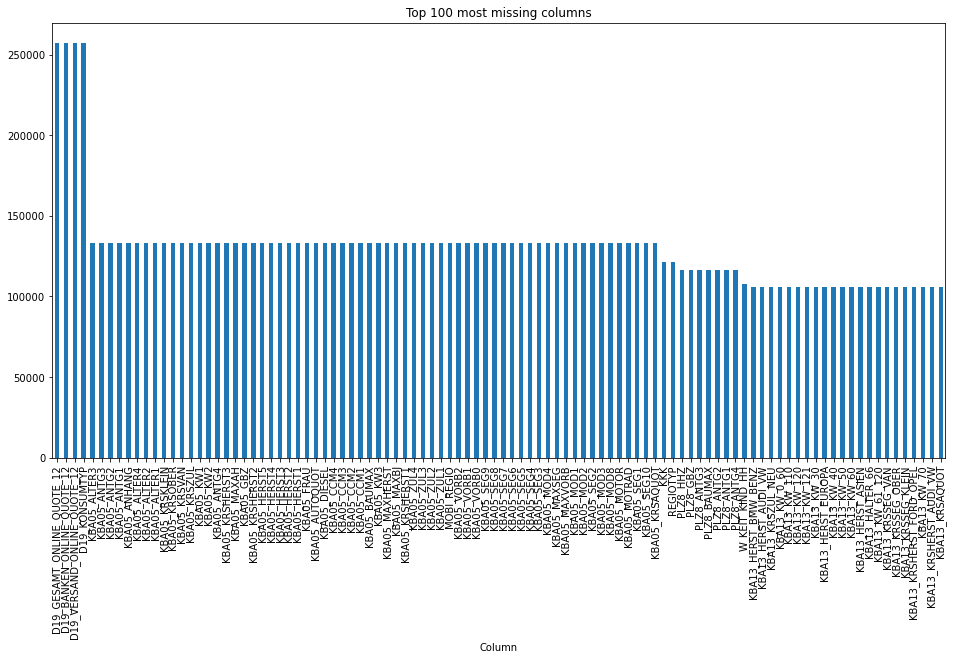

For more information about the features two Excel spreadsheets were provided by Udacity. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In `./DIAS Attributes - Values 2017.xlsx` values and their respective meanings are depicted, as shown below.

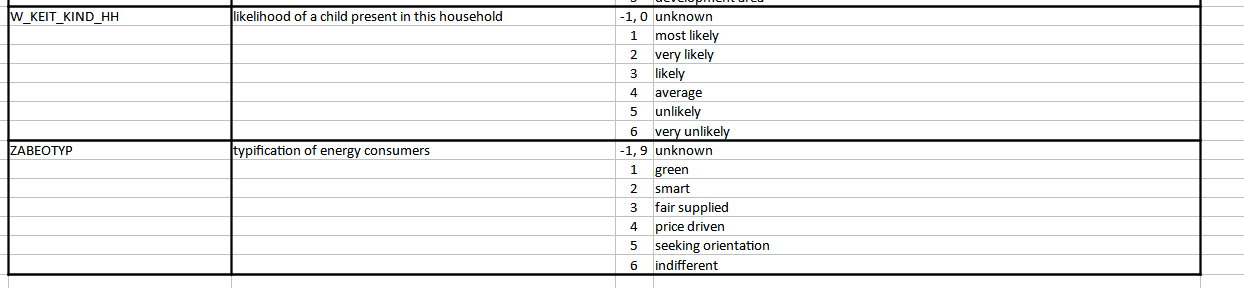

Missing data is handled subsequently as follows:
    
- Drop all columns whose meaning is not known from `./DIAS Information Levels - Attributes 2017.xlsx`.
- Impute missing values based on values from `./DIAS Attributes - Values 2017.xlsx` representing missing values.
- Categorical values are encoded via Pandas `get_dummies()`.

In [ ]:
# set up attribute-unknown map
unknowns_map = {}
for _, row in attribute2value_unknowns.iterrows():
    key = row["Attribute"]
    # Set first value as unknown
    unknowns_map[key] = int(row["Value"].split(", ")[0])
    
# fill nan with unknowns from above map
azdias.fillna(unknowns_map, inplace = True)

After cleaning and encoding, the dataset contains of 798073 people and 307 features.

All cleaning steps are stored in the following function:

In [ ]:
def clean_df(df, unknowns_map = {}, columns_to_drop = {}):
    """
    Cleans the dataframe:
    - Drop features based on azdias_not_in_attribute_list
    - Convert missing values based on unknowns_map
    - Re-encode categorical features
    
    params:
    - df (DataFrame): the Dataframe to be cleaned and preprocessed
    - unknowns_map (dict): the map containing the key-value pairs to map attribute and unknown representation
    - columns_to_drop (list): list of features to be dropped
    
    returns:
    - df_cleaned (Dataframe): to cleaned Dataframe
    """
    # drop features
    df_cleaned = df.copy()
    print('copy: {}'.format(df_cleaned.shape))
    df_cleaned = df_cleaned.drop(labels=columns_to_drop, axis=1)
    
            
    df_cleaned.loc[df_cleaned['CAMEO_DEUG_2015'] == 'X','CAMEO_DEUG_2015'] = np.nan
    df_cleaned['CAMEO_DEUG_2015'] = df_cleaned['CAMEO_DEUG_2015'].astype('float64').astype('Int64')
    
    # fill nan with unknowns from above map
    df_cleaned.fillna(unknowns_map, inplace = True)
    df_cleaned = df_cleaned.fillna(df_cleaned.median())
    
    print('fill unknowns: {}'.format(df_cleaned.shape))
    
    # Map categorical values
    df_cleaned = pd.get_dummies(df_cleaned, columns=['CAMEO_DEU_2015'], prefix='CAMEO_DEU_2015', dtype = np.int64, drop_first=True)
    
    print('map categories: {}'.format(df_cleaned.shape))
    
    df_cleaned['OST_WEST_KZ'] = df_cleaned['OST_WEST_KZ'].map({'W': 1.0, 'O': -1.0})
    
    print('map ost west: {}'.format(df_cleaned.shape))
    # Fill in NaNs after merge   
    df_cleaned.fillna(0.0, inplace=True)
    
    print('fill nans after merge: {}'.format(df_cleaned.shape))
    
    # Fix datatypes
    for column in df_cleaned.columns:
        if df_cleaned[column].dtype == (np.int64 or 'Int64'):
            df_cleaned[column] = df_cleaned[column].astype(np.float64)
    df_cleaned.CAMEO_DEUG_2015 = df_cleaned.CAMEO_DEUG_2015.astype('float64')
    
    # Print new shape and datatypes
    print("Before: {}".format(df.shape))
    print("After: {} \n".format(df_cleaned.shape))
    print("Datatypes:")
    print(df_cleaned.dtypes.value_counts())
    
    return df_cleaned

Cleaning the `customers` dataset in a similar way results in 191652 customers and 307 features.

## Methodology <a name="methodolgy"></a>

### Preprocessing <a name="preprocessing"></a>

- **Feature scaling**

Features are scaling using a standard scaler. By doing so features are standardized by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

In [ ]:
# Initialize standard scaler
scaler = StandardScaler()
# apply Standard scaler to AZDIAS
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_cleaned), columns = azdias_cleaned.columns)
# apply Standard scaler to CUSTOMERS
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_cleaned), columns = customers_cleaned.columns)

### Implementation <a name="implementation"></a>

In this section, I will add the implementation details of the machine learning (unsupervised
and supervised) algorithms.

#### Dimensionality Reduction with PCA

I used a scree plot visualisation in order to decide the number of principal components I want to have for the. The goal is to keep the number of principal components that will explain 95% of the variance in the data.

The scree plot is used to determine the number of factors to retain in an exploratory factor analysis (FA) or principal components to keep in a principal component analysis (PCA).

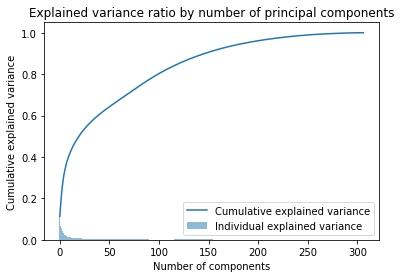

I want to construct the number of features such that most of the variance is explained by the components. As a threshold, 95% is used.

Of the over 300 features in the original dataset 188 can be used to explain 95% of the variance. This means the dataset can be reduced by almost half of its features while only losing 5% of variance.

In [ ]:
# Perform PCA with latent features for AZDIAS
pca = PCA(n_components=n_components)
reduced_azdias = pd.DataFrame(pca.fit_transform(azdias_scaled))
print('The variance in the data explained by the principal components after employing PCA is equal to {}'.format(pca.explained_variance_ratio_.sum()))

The variance in the data explained by the principal components after employing PCA is equal to 0.9495216571736814


#### Clustering via k-means

When clustering with k-means, the number k of clusters serves as a hyperparameter of
the algorithm. The ‘optimal’ k is found using the Elbow Method (see https://en.wikipedia.org/wiki/Elbow_method_(clustering)).
Do so, PCA is computed an 1-18 clusters.

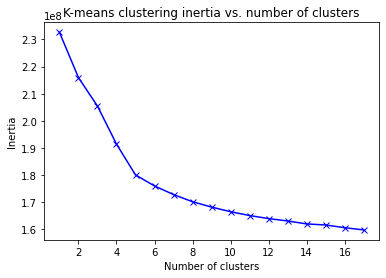

From above plot we see a clear elbow at k=5 clusters. We therefore conclude to use 5 clusters for further unsupervised learning. In case that 5 clusters are too imprecise, I will use k=11 clusters as an alternative as this is where a linear decline in inertia starts.

 - **k=5**:
    
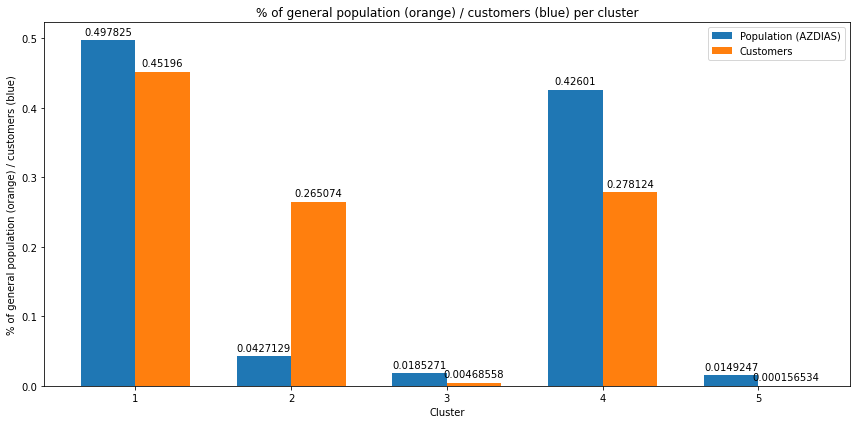

Above plot displays the distribution of the general population and customers across all clusters. We also see that ~50% of the population is grouped in the same cluster. We also see that people from cluster 3 are slightly overrepresented in the customer base, but it seems too narrow for statistical significance. From this information I conclude that the number of clusters is too low and I will redo predictions with k=11 clusters.

- **k=11**:

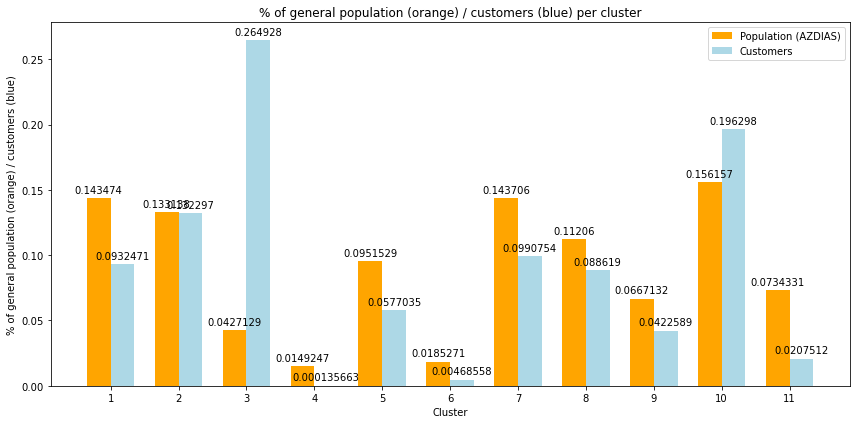

Again, above plot visualized the distribution of general population and customers across all - now 11 - clusters. We also see that clusters 3 and 10 are strongly overrepresented in the customer base, indicating that it might me useful to target people from these clusters from the general population.

Comparing above features for overrepresented clusters (1,10) to underrepresented clusters (3,5), we see the following saliences:

*Overrepresented clusters*

- tend to be more in western Germany
- tend to have above-average salary
- tend to be from smaller party households, probably due to higher salaries
- have high online affinity
- tend to have higher financial literacy (invest and safe)

*Underrepresented clusters*

- tend to earn less
- tend to be in many-party-households
- tend to be more in eastern Germany

#### Supervised learning model

After loading the training dataset `mailout_train`, I noticed a class imbalance problem, where most responses were 0, i.e. did not become customer. As this causes supervised learning classifiers to lean towards 0-predictions, I needed to find a strategy for this issue.

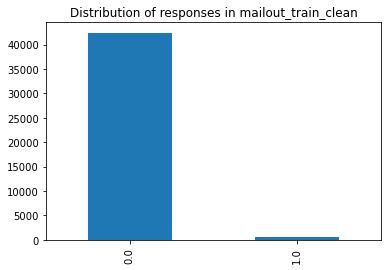

I resample the set of positive responses in a way to obtain an equal number of positive and negative responses. By that, I hope to reduce the effect.

In [ ]:
# split dataset
positives = mailout_train_clean[mailout_train_clean['RESPONSE']==1] 
negatives = mailout_train_clean[mailout_train_clean['RESPONSE']==0]
# resample to obtain equal sample sizes
positives_balanced = resample(positives, replace=True, n_samples=len(negatives), random_state=42) 
# Combine balanced data sets of positive and negative responses
mailout_train_balanced = pd.concat([negatives, positives_balanced])

After resampling, the training set contains 42430 positives and 42430 negatives.

I will perform supervised learning using a variety of supervised learning algorithms. Different algorithms are compared using the ROC AUC (area under the ROC curve) score. Each model is run 5 times (cv=5) and the best result is kept.

In [ ]:
# different supervised learning classifiers
models = {'LogisticRegression': LogisticRegression(),
          'RandomForestClassifier': RandomForestClassifier(), 
          'AdaBoostClassifier': AdaBoostClassifier(), 
          'GradientBoostingClassifier': GradientBoostingClassifier()
         }

##### Benchmark: Logistic regression

In [ ]:
# fit logistic regression classifier
grid_lr = GridSearchCV(estimator=LogisticRegression(random_state = 42), param_grid={}, scoring='roc_auc', cv=5)
grid_lr.fit(X_train, y)

This gives a best ROC AUC score of 0.7642492543901869.

##### Random forest

In [ ]:
# fit random forest classifier 
grid_rf = GridSearchCV(estimator=RandomForestClassifier(random_state = 42), param_grid={}, scoring='roc_auc', cv=5)
grid_rf.fit(X_train, y)

This gives a best ROC AUC score of 0.9936156189432135.

The result of the random forest classifier seems too high for the training data and might be the result of overfitting.

##### AdaBoost

In [ ]:
# fit AdaBoost classifier
grid_ab = GridSearchCV(estimator=AdaBoostClassifier(random_state = 42), param_grid={}, scoring='roc_auc', cv=5)
grid_ab.fit(X_train, y)

This gives a best ROC AUC score of 0.7234375563272643.

##### Gradient boosting

In [ ]:
# fit Gradient boosting classifier
grid_gb = GridSearchCV(estimator=GradientBoostingClassifier(random_state = 42), param_grid={}, scoring='roc_auc', cv=5)
grid_gb.fit(X_train, y)

This gives a best ROC AUC score of 0.9142034093780449.

The gradient boosting model seems promising and is to be used for further model tuning.

#### Model tuning

The overall parameters of this ensemble model can be divided into 2 categories:

- Tree-Specific Parameters: These affect each individual tree in the model.
- Boosting Parameters: These affect the boosting operation in the model.

In this particular case, I focus on `max_depth` to control overfitting as a tree-specific parameter and `n_estimators` as the number of trees as a boosting parameter.

In [ ]:
# set model param map
params_gb = {'max_depth': range(4,9,2),
            'n_estimators': range(20,81,10)
            }

# fit gradient boosting classifier with param grid
grid_gb = GridSearchCV(estimator=GradientBoostingClassifier(random_state = 42), param_grid=params_gb, scoring='roc_auc', cv=5)
grid_gb.fit(X_train, y)

After model tuning, I receive a best ROC AUC score of 0.9925656093031797.

This value does seem suspicious in terms of overfitting, but I will evaluate it nevertheless using test data.

## Results and Kaggle submission <a name="results"></a>

The final model I chose for the predictions is a parameter-tuned GradientBoostingClassifier, achieving a score of 0.99 on the mailout training dataset.

The RandomForestClassifier was not taking because its score hinted towards an overfitting issue.

The final GradientBoostingClassifier model obtained an AUC of the ROC curve of 0.5612 on the test dataset (see https://www.kaggle.com/c/udacityarvato-identify-customers/leaderboard)

## Conclusion <a name="conclusion"></a>

The Bertelsmann/Arvato Projest was a fun capstone project in the Data Science Nanodegree program. Handling the data load proved to be very challenging, especially cleaning and preparing the different features for further modelling steps.

In the unsupervised learning part, customers and the general population were clustered into 11 groups. Two groups were highly present among customers compared to the general population. These two focus groups had specific characteristics: Broadly speaking, typically well-earning couples, people from west germany or families with higher education.

To forecast customer responses, the Gradient Boosting Classifier proved to be the best-performing estimator. The Kaggle submission results shows that there is still room for improvement. Possible areas for further investigation could be:

Drop fewer or more data points when preparing the datasets.
Test different approaches to standardize and scale features, like using Min-Max-Scaler instead of Standard Scaler.
Choose a smaller or bigger number of clusters to group customers and population.
I hope to return to this project to further improve forcasts.